In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import cv2
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model
from tensorflow.keras import callbacks
from tqdm import tqdm

2023-08-25 21:15:46.385489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 21:15:46.488899: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 21:15:46.489748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 21:15:47.277257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
classes = {'AbdomenCT': 0, 'BreastMRI': 1, 'ChestCT': 2, 'CXR': 3, 'Hand': 4, 'HeadCT': 5}

In [3]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 64
N_CLASSES = 6
EPOCHS = 5

In [4]:
abdomen_DIR='medical-mnist/AbdomenCT'
breastmri_DIR='medical-mnist/BreastMRI'
chestct_DIR='medical-mnist/ChestCT'
cxr_DIR='medical-mnist/CXR'
hand_DIR='medical-mnist/Hand'
headct = 'medical-mnist/HeadCT'

In [5]:
def assign_label(img,class_type):
    return class_type

X = []
y = []

def make_train_data(class_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

In [6]:
make_train_data(classes.get('AbdomenCT'), abdomen_DIR)

100%|██████████| 10000/10000 [00:01<00:00, 8059.96it/s]


In [7]:
make_train_data(classes.get('BreastMRI'), breastmri_DIR)

100%|██████████| 8954/8954 [00:01<00:00, 8238.88it/s]


In [8]:
make_train_data(classes.get('ChestCT'), chestct_DIR)

100%|██████████| 10097/10097 [00:01<00:00, 7163.61it/s]


In [9]:
make_train_data(classes.get('CXR'), cxr_DIR)

100%|██████████| 10000/10000 [00:01<00:00, 7721.61it/s]


In [10]:
make_train_data(classes.get('Hand'), hand_DIR)

100%|██████████| 10000/10000 [00:01<00:00, 7833.15it/s]


In [11]:
make_train_data(classes.get('HeadCT'), headct)

100%|██████████| 10000/10000 [00:01<00:00, 8122.99it/s]


In [12]:
len(X)
y = np.array(y)
X = np.array(X)
X.shape

(59051, 64, 64, 3)

In [13]:
X.shape, y.shape

((59051, 64, 64, 3), (59051,))

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=58954)

In [15]:
k = len(set(y_train))
print("Number of classes, ", k)

Number of classes,  6


In [16]:
X_train = X_train.astype('float64')/255
X_test = X_test.astype('float64')/255

In [17]:
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [18]:
labels = '''AbdomenCT
BreastMRI
ChestCT
CXR
Hand
HeadCT'''.split("\n")

In [19]:
i = layers.Input(shape = (X_train[0].shape))
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(i)
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(k, activation='softmax')(x)

model = Model(i, x)

2023-08-25 21:16:20.176513: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_lr=0.00001)

model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data =  (X_test,y_test), callbacks=[reduce_lr])

2023-08-25 21:16:34.851592: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2612183040 exceeds 10% of free system memory.


Epoch 1/5
831/831 [==============================] - 23s 27ms/step - loss: 0.0693 - accuracy: 0.9774 - val_loss: 0.0040 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 2/5
831/831 [==============================] - 21s 25ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0050 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 3/5
831/831 [==============================] - 21s 25ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0028 - val_accuracy: 0.9993 - lr: 0.0010
Epoch 4/5
831/831 [==============================] - 21s 25ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0010 - val_accuracy: 0.9997 - lr: 0.0010
Epoch 5/5
831/831 [==============================] - 21s 25ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0043 - val_accuracy: 0.9995 - lr: 0.0010


The class of this is: 2


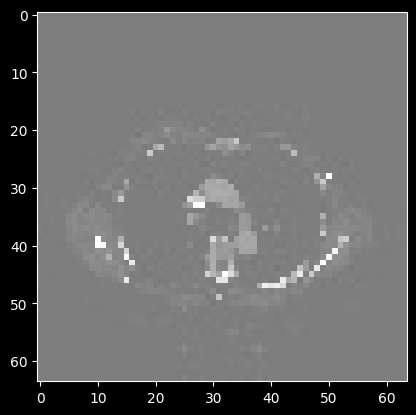

In [22]:
print("The class of this is: {}".format(np.argmax(y_train[10])))
plt.imshow(X_train[10], cmap='gray')
plt.show()

185/185 [==============================] - 1s 3ms/step
[[ 995    0    0    0    0    0]
 [   0  858    0    0    0    0]
 [   0    0 1041    0    0    0]
 [   0    1    0 1011    1    0]
 [   0    0    0    0  994    1]
 [   0    0    0    0    0 1004]]


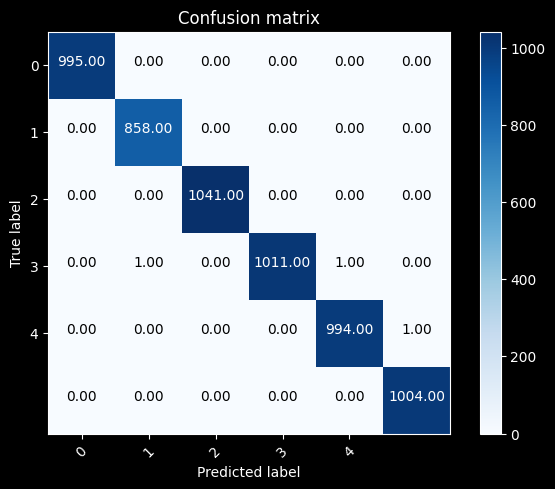

In [24]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',                                                                                                                                 
                          cmap=plt.cm.Blues):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(np.argmax(y_test, axis= 1), p_test)
plot_confusion_matrix(cm, list(range(5)))


In [ ]:
# tf.keras.models.save_model(model,"mednist.h5")

In [ ]:
# model = tf.keras.models.load_model("medMnist.h5")